In [154]:
!pip install pyswarms



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [155]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import pyswarms as ps

In [156]:
# TODO

# mostrar mejores individuos y sus costes finales de cada ejecución
# más pruebas???

# Práctica 1: Optimización Mono-objetivo (Himmelblau)

En este bloque abordamos la optimización de la **Función de Himmelblau**, un problema multimodal clásico en optimización definido por la siguiente ecuación:

$$f(x,y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2$$

El objetivo matemático es encontrar el mínimo global donde $f(x,y)=0$. Esta función presenta 4 mínimos globales idénticos en el rango de búsqueda, lo que añade dificultad para que el algoritmo no se estanque en óptimos locales.

### Estrategia de Diseño
Dado que el dominio de búsqueda es continuo ($x, y \in [-5, 5]$), hemos optado por un **Algoritmo Genético con Codificación Real**.

* **Función de Fitness:** El problema original es de *minimización*. Para adaptarlo al funcionamiento canónico de un GA (que busca *maximizar* aptitud), aplicamos la siguiente transformación:
$$Fitness = \frac{1}{1 + f(x,y)}$$
De esta forma, un coste de $0$ se convierte en un fitness de $1.0$.

In [157]:
# Función himmelblau
# si se pone onlyone a True

onlyone = False
def himmelblau (ch):
	x = ch[0]
	y = ch[1]
	fxy = (x**2 + y - 11)**2 + (x + y**2 -7)**2
	if onlyone and (x>0 or y>0): # himmelblau modified to have only one global minimum (-3.77, -3.28)
		fxy += 0.5
	return fxy

In [158]:
# fitness para himmelblau: valor mínimo de la función

def fitness_himmel (ch):
	return 1 / (1 + himmelblau(ch))

### Implementación de Operadores Genéticos

Para garantizar una exploración eficiente en un espacio continuo, hemos descartado los operadores binarios clásicos en favor de operadores específicos para variables reales:

1.  **Cruce BLX-Alpha:**
    * A diferencia del cruce simple, este operador genera descendencia en un intervalo que cubre la distancia entre los padres extendida un factor $\alpha$.
    * **Justificación:** Permite mantener la diversidad y evita que la población converja prematuramente hacia el centroide de los padres, favoreciendo la **exploración**.

2.  **Mutación Gaussiana:**
    * Añade un ruido con distribución normal ($\mu=0, \sigma=0.5$) a los genes.
    * **Justificación:** Actúa como un mecanismo de **búsqueda local**, refinando las soluciones con pequeños ajustes precisos, lo cual es vital para alcanzar errores del orden de $10^{-17}$.

In [159]:
def seleccion_torneo(pop, fitnesses, T):
    """Devuelve un individuo (el mejor de T aleatorios)."""
    idxs = np.random.choice(len(pop), T, replace=False)
    best_local = idxs[np.argmax([fitnesses[i] for i in idxs])]  # max porque fitness = 1/(1+f)
    return pop[best_local]

def cruce_blx_alpha_logic(padre1, padre2, alpha=0.5):
    """BLX-alpha en 2D."""
    hijo = np.zeros(2)
    for i in range(2):
        c_min = min(padre1[i], padre2[i])
        c_max = max(padre1[i], padre2[i])
        diff = c_max - c_min
        lower = c_min - diff * alpha
        upper = c_max + diff * alpha
        gen = np.random.uniform(lower, upper)
        hijo[i] = np.clip(gen, rang[0], rang[1])
    return hijo

def mutacion_gaussiana_logic(ind, sigma=0.5):
    """Suma ruido gaussiano a cada gen."""
    hijo = ind.copy()
    hijo += np.random.normal(0, sigma, size=hijo.shape)
    hijo = np.clip(hijo, rang[0], rang[1])
    return hijo

In [160]:
# Define operadores de números reales

rang = (-5, 5) # al no hacerlo con clases, debemos definir el rango como variable global

def create(alphabet=None, N=100):
    """Población inicial (N individuos), cada individuo es [x,y]."""
    return [np.random.uniform(rang[0], rang[1], 2) for _ in range(N)]

def crossover(ind1, ind2, pcross):
    """Cruce BLX-alpha con probabilidad pcross (devuelve 1 hijo)."""
    if random.random() < pcross:
        return cruce_blx_alpha_logic(ind1, ind2, alpha=0.5)
    # si no cruza, copia uno de los padres (para no clonar siempre el mismo)
    return ind1.copy() if random.random() < 0.5 else ind2.copy()

def mutate(ind, pmut, sigma):
    """Mutación gaussiana con probabilidad pmut (por individuo)."""
    if random.random() < pmut:
        return mutacion_gaussiana_logic(ind, sigma=sigma)
    return ind.copy()


### Motor evolutivo y Condición de parada

El núcleo del algoritmo (`evolve`) orquesta la selección (por torneo), el cruce y la mutación, incorporando dos aspectos clave para cumplir los requisitos, por un lado, se aplica elitismo, de modo que el mejor individuo de cada generación pasa intacto a la siguiente y nunca se pierde la mejor solución encontrada, manteniendo así una convergencia monótona, por otro lado, la condición de parada no depende solo del número de generaciones, sino que se detiene estrictamente al alcanzar las **3.500 evaluaciones**, garantizando una comparativa justa (mismo esfuerzo computacional) frente a otros algoritmos como el PSO.

In [161]:
def evolve(pop, fitness_fn, pmut, ngen, trace, T, pcross, sigma, elitism=True):
    MAX_EVALS = 3500

    # Evaluamos población inicial (esto SÍ cuenta)
    pop_fitness = [fitness_fn(ind) for ind in pop]
    evaluaciones = len(pop)

    best_idx = np.argmax(pop_fitness)
    best_fit = pop_fitness[best_idx]
    best_ind = pop[best_idx].copy()

    best_history = [best_fit]
    siguiente_reporte = 600

    gen = 0
    while gen < ngen and evaluaciones < MAX_EVALS:
        if elitism:
            next_pop = [best_ind.copy()]
            next_fit = [best_fit]
        else:
            next_pop = []
            next_fit = []

        # Creamos el resto de la población
        while len(next_pop) < len(pop) and evaluaciones < MAX_EVALS:
            # torneo padre 1
            candidates = np.random.choice(len(pop), T, replace=False)
            p1_idx = candidates[np.argmax([pop_fitness[i] for i in candidates])]
            parent1 = pop[p1_idx]

            # torneo padre 2
            candidates = np.random.choice(len(pop), T, replace=False)
            p2_idx = candidates[np.argmax([pop_fitness[i] for i in candidates])]
            parent2 = pop[p2_idx]

            child = crossover(parent1, parent2, pcross)
            child = mutate(child, pmut, sigma)

            # Evaluación REAL (esto es lo que cuenta)
            child_fit = fitness_fn(child)
            evaluaciones += 1

            next_pop.append(child)
            next_fit.append(child_fit)

            if child_fit > best_fit:
                best_fit = child_fit
                best_ind = child.copy()

        pop = next_pop
        pop_fitness = next_fit

        best_history.append(best_fit)

        if trace and evaluaciones >= siguiente_reporte:
            print(f"Evaluaciones: {evaluaciones}, Mejor fitness: {best_fit:.16f}")
            siguiente_reporte += 500

        gen += 1

    return best_ind, best_history

### ¿Cómo afectan algunos parámetros clave al comportamiento de mi algoritmo genético?

Se realizó un estudio paramétrico variando los parámetros σ de la mutación gaussiana, el tamaño del torneo y el uso de elitismo.
Inicialmente se evaluaron 24 configuraciones distintas mediante 10 ejecuciones independientes, seleccionando las más prometedoras en función del coste medio.
Posteriormente, las configuraciones finalistas fueron evaluadas con 10 ejecuciones independientes, eligiéndose como configuración final aquella que presentó el menor coste medio y menor variabilidad.

In [162]:
configs = []

for sigma in [0.2, 0.3, 0.5, 0.8]:
    for T in [2, 3, 4]:
        for elitism in [True, False]:
            configs.append({
                "sigma": sigma,
                "T": T,
                "elitism": elitism
            })


In [163]:
def evaluate_config(cfg, n_runs=3):
    final_costs = []

    for _ in range(n_runs):
        pop = create(N=50)

        best, _ = evolve(
            pop,
            fitness_himmel,
            pmut=0.2,
            ngen=1000,
            trace=False,
            T=cfg["T"],
            pcross=0.9,
            sigma=cfg["sigma"],
            elitism=cfg["elitism"]
        )

        final_costs.append(himmelblau(best))

    return {
        "mean": np.mean(final_costs),
        "std": np.std(final_costs),
        "best": np.min(final_costs)
    }


In [164]:
results = []

for cfg in configs:
    stats = evaluate_config(cfg, n_runs=10)
    results.append({**cfg, **stats})
    print(cfg, stats)

results_sorted = sorted(results, key=lambda x: x["mean"])
top_configs = results_sorted[:3]

final_results = []

for cfg in top_configs:
    stats = evaluate_config(cfg, n_runs=10)
    final_results.append({**cfg, **stats})

{'sigma': 0.2, 'T': 2, 'elitism': True} {'mean': 4.8828105223227024e-11, 'std': 8.530076831869661e-11, 'best': 3.912839689998636e-14}
{'sigma': 0.2, 'T': 2, 'elitism': False} {'mean': 4.745720125271403e-08, 'std': 6.421654440475616e-08, 'best': 2.2305230456137983e-10}
{'sigma': 0.2, 'T': 3, 'elitism': True} {'mean': 1.3174158608999304e-10, 'std': 3.876825515285154e-10, 'best': 4.903219508771535e-18}
{'sigma': 0.2, 'T': 3, 'elitism': False} {'mean': 5.922307157742633e-09, 'std': 1.7766901281388154e-08, 'best': 3.9970648339595724e-19}
{'sigma': 0.2, 'T': 4, 'elitism': True} {'mean': 7.307302430366583e-06, 'std': 2.174191527952191e-05, 'best': 3.349604811142062e-17}
{'sigma': 0.2, 'T': 4, 'elitism': False} {'mean': 1.1932877780894702e-10, 'std': 3.4747648653468306e-10, 'best': 1.55222672647947e-17}
{'sigma': 0.3, 'T': 2, 'elitism': True} {'mean': 2.937039217464187e-11, 'std': 4.4327001680607495e-11, 'best': 4.1839347302179505e-16}
{'sigma': 0.3, 'T': 2, 'elitism': False} {'mean': 5.215343

In [165]:
labels = [
    f"σ={r['sigma']}, T={r['T']}, elit={r['elitism']}"
    for r in results
]

means = [r["mean"] for r in results]
stds  = [r["std"] for r in results]

best_idx = np.argmin(means)

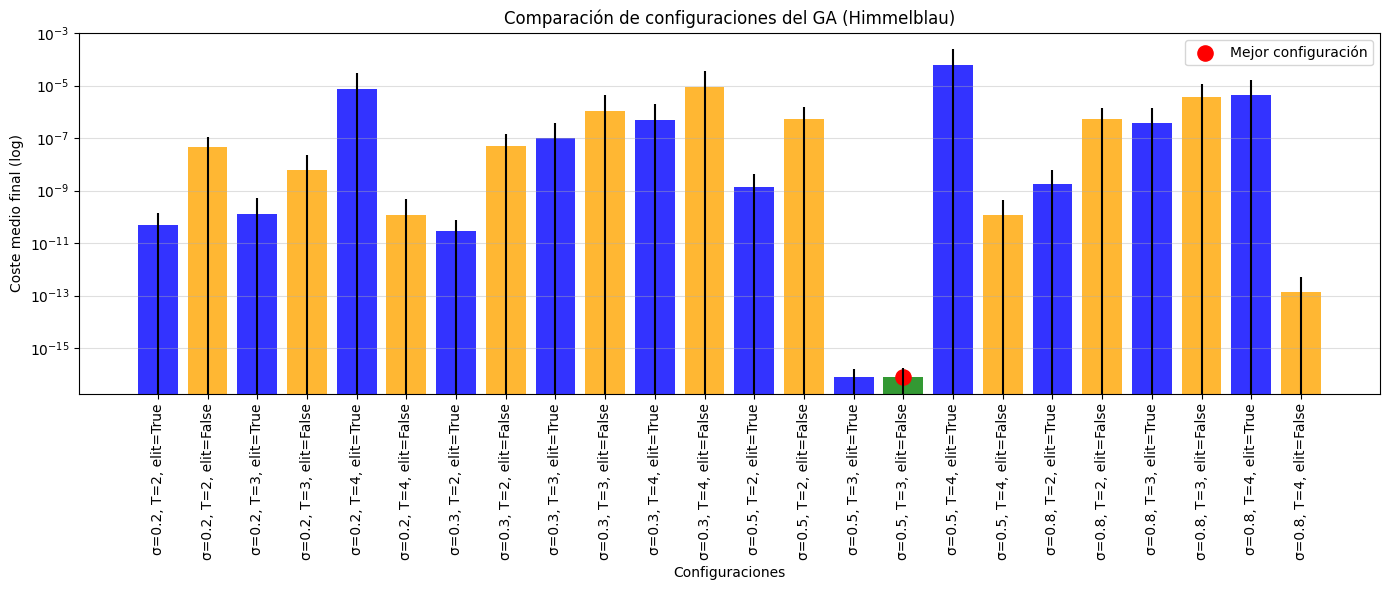

✅ Mejor configuración encontrada:
{'sigma': 0.5, 'T': 3, 'elitism': False, 'mean': 7.672479065746394e-17, 'std': 9.14873547659093e-17, 'best': 2.5220157168737205e-18}


In [166]:
plt.figure(figsize=(14,6))

colors = ["green" if i == best_idx else
          "blue" if results[i]["elitism"] else
          "orange"
          for i in range(len(results))]

plt.bar(range(len(means)), means, yerr=stds, color=colors, alpha=0.8)

plt.yscale("log")
plt.ylabel("Coste medio final (log)")
plt.xlabel("Configuraciones")
plt.title("Comparación de configuraciones del GA (Himmelblau)")

plt.xticks(range(len(labels)), labels, rotation=90)

plt.scatter(
    best_idx,
    means[best_idx],
    color="red",
    s=120,
    label="Mejor configuración"
)

plt.legend()
plt.grid(True, axis="y", alpha=0.4)
plt.tight_layout()
plt.show()

# Ordenar por mejor rendimiento medio
results_sorted = sorted(results, key=lambda x: x["mean"])

# Guardamos la mejor configuración
best_config = results_sorted[0]

print("✅ Mejor configuración encontrada:")
print(best_config)

BEST_SIGMA = best_config["sigma"]
BEST_T = best_config["T"]
BEST_ELITISM = best_config["elitism"]



Ejecuciones

 Ejecución 1 
Evaluaciones: 600, Mejor fitness: 0.9828970344035393
Evaluaciones: 1100, Mejor fitness: 0.9959278753488779
Evaluaciones: 1600, Mejor fitness: 0.9981221133262398
Evaluaciones: 2100, Mejor fitness: 0.9982156138295837
Evaluaciones: 2600, Mejor fitness: 0.9982944345879463
Evaluaciones: 3100, Mejor fitness: 0.9983212930719642

 Ejecución 2 
Evaluaciones: 600, Mejor fitness: 0.9996546816047727
Evaluaciones: 1100, Mejor fitness: 0.9999994347448877
Evaluaciones: 1600, Mejor fitness: 0.9999999999366878
Evaluaciones: 2100, Mejor fitness: 0.9999999999999165
Evaluaciones: 2600, Mejor fitness: 0.9999999999999998
Evaluaciones: 3100, Mejor fitness: 1.0000000000000000

 Ejecución 3 
Evaluaciones: 600, Mejor fitness: 0.9989666363694846
Evaluaciones: 1100, Mejor fitness: 0.9999986729097975
Evaluaciones: 1600, Mejor fitness: 0.9999999999894749
Evaluaciones: 2100, Mejor fitness: 0.9999999999999931
Evaluaciones: 2600, Mejor fitness: 1.0000000000000000
Evaluaciones: 3100, Mejor fi

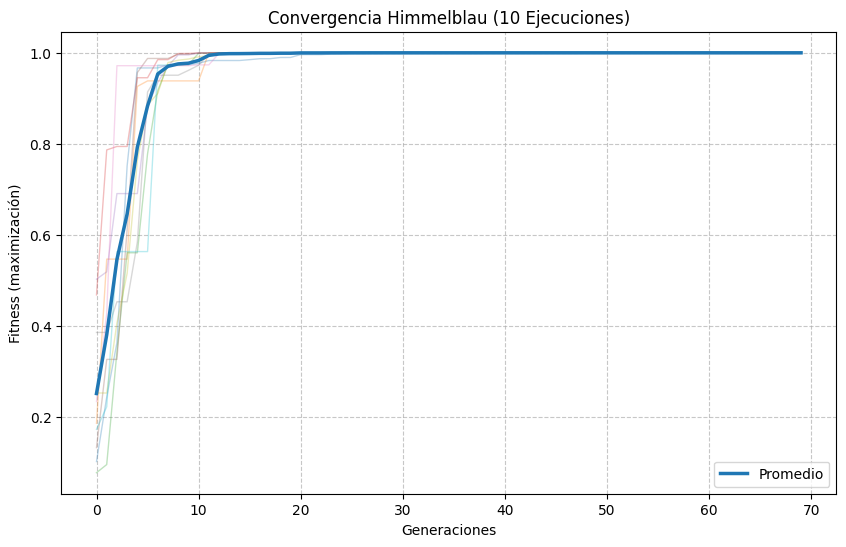

In [167]:
print("Ejecuciones\n")
all_histories = []
ga_best_solutions = []
ga_final_costs = []

for i in range(10):
    print(f" Ejecución {i+1} ")
    pop_ini = create(N=50)
    best_sol, hist = evolve(pop_ini, fitness_himmel, pmut=0.2, ngen=1000, trace=True, T=BEST_T, pcross=0.9, sigma=BEST_SIGMA, elitism=BEST_ELITISM)
    ga_best_solutions.append(best_sol)
    ga_final_costs.append(himmelblau(best_sol))
    all_histories.append(hist)
    print("")

plt.figure(figsize=(10, 6))

for h in all_histories:
    plt.plot(h, alpha=0.3, linewidth=1)

min_len = min(len(h) for h in all_histories)
avg_history = np.mean([h[:min_len] for h in all_histories], axis=0)
plt.plot(avg_history, linewidth=2.5, label='Promedio')

plt.title("Convergencia Himmelblau (10 Ejecuciones)")
plt.xlabel("Generaciones")
plt.ylabel("Fitness (maximización)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Convertimos historiales GA de fitness -> coste para comparar con PSO
# fitness = 1/(1+f)  =>  f = (1/fitness) - 1
eps = 1e-12
ga_cost_histories = [ [(1/max(v, eps)) - 1 for v in h] for h in all_histories ]

min_len_ga = min(len(h) for h in ga_cost_histories)
hist_coste_ga = np.mean([h[:min_len_ga] for h in ga_cost_histories], axis=0)

### Análisis de los resultados

En las 10 ejecuciones, el algoritmo converge de forma rápida y consistente: la mayor mejora se produce en las primeras generaciones y después la curva se estabiliza, señal de que ya se está muy cerca del mínimo. A partir de ~2000-3000 evaluaciones, la mayoría de ejecuciones alcanzan valores prácticamente óptimos y el progreso posterior es muy pequeño (mejora fina).

También se observa baja variabilidad entre ejecuciones: aunque al inicio algunas trayectorias son más lentas que otras, todas terminan llegando a soluciones de calidad similar. En conjunto, los resultados muestran un comportamiento estable y una convergencia fiable bajo el mismo presupuesto de evaluaciones.

# Comparativa con PSO

Se aplica PSO a Himmelblau con un presupuesto equivalente al del GA (3500 evaluaciones), trabajando en dos dimensiones y dentro del dominio ([-5,5]). Para ello se adapta la función de Himmelblau al formato requerido por `pyswarms`, de forma que pueda evaluar en vector el coste de todas las partículas en cada iteración. Se realizan 10 ejecuciones independientes para medir estabilidad y rendimiento, registrando la convergencia en cada una y obteniendo una curva media para comparar de manera justa con el GA.

In [168]:
N_PARTICULAS = 50
ITERACIONES = 70  # 50*70 = 3500 evaluaciones (mismo presupuesto que GA)
DIMENSIONES = 2

LIMITES = (np.full(DIMENSIONES, -5.0), np.full(DIMENSIONES, 5.0))

def himmelblau_pyswarms(X):
    # X: (n_particulas, 2)
    x = X[:, 0]
    y = X[:, 1]
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

In [169]:
pso_histories = []
pso_final_values = []
pso_best_positions = []

for i in range(10):
    optimizer = ps.single.GlobalBestPSO(
        n_particles=N_PARTICULAS,
        dimensions=DIMENSIONES,
        options=options,
        bounds=LIMITES
    )

    cost, pos = optimizer.optimize(himmelblau_pyswarms, iters=ITERACIONES, verbose=False)
    pso_histories.append(optimizer.cost_history)
    pso_final_values.append(cost)
    pso_best_positions.append(pos)
    print(f"Ejecución PSO {i+1}: Coste final = {cost:.10f}")

# Promedio PSO (coste)
min_len_pso = min(len(h) for h in pso_histories)
hist_coste_pso = np.mean([h[:min_len_pso] for h in pso_histories], axis=0)

Ejecución PSO 1: Coste final = 0.0000451272
Ejecución PSO 2: Coste final = 0.0000160959
Ejecución PSO 3: Coste final = 0.0001358232
Ejecución PSO 4: Coste final = 0.0001190491
Ejecución PSO 5: Coste final = 0.0006842492
Ejecución PSO 6: Coste final = 0.0000305293
Ejecución PSO 7: Coste final = 0.0000137716
Ejecución PSO 8: Coste final = 0.0002355968
Ejecución PSO 9: Coste final = 0.0001088952
Ejecución PSO 10: Coste final = 0.0000204271


In [170]:
media_pso = np.mean(pso_final_values)
std_pso = np.std(pso_final_values)
mejor_pso = np.min(pso_final_values)

print("ESTADÍSTICAS PSO (10 ejecuciones)")
print(f"Media coste: {media_pso:.10f}")
print(f"Desviación típica: {std_pso:.10f}")
print(f"Mejor ejecución: {mejor_pso:.10f}")

ESTADÍSTICAS PSO (10 ejecuciones)
Media coste: 0.0001409565
Desviación típica: 0.0001932172
Mejor ejecución: 0.0000137716


In [171]:
pso_final_fitness = [1.0 / (1.0 + c) for c in pso_final_values]

media_fit = np.mean(pso_final_fitness)
std_fit = np.std(pso_final_fitness)
mejor_fit = np.max(pso_final_fitness)

print("ESTADÍSTICAS PSO (10 ejecuciones) - FITNESS")
print(f"Media fitness: {media_fit:.16f}")
print(f"Desviación típica: {std_fit:.16f}")
print(f"Mejor ejecución (fitness): {mejor_fit:.16f}")

ESTADÍSTICAS PSO (10 ejecuciones) - FITNESS
Media fitness: 0.9998591007116422
Desviación típica: 0.0001930835483999
Mejor ejecución (fitness): 0.9999862285973359


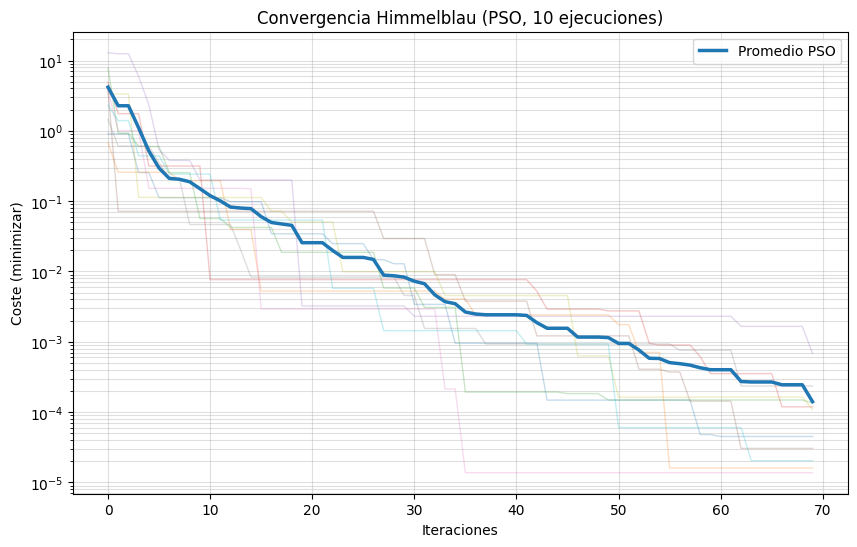

In [172]:
plt.figure(figsize=(10, 6))

for h in pso_histories:
    plt.plot(h, alpha=0.25, linewidth=1)

plt.plot(hist_coste_pso, linewidth=2.5, label='Promedio PSO')
plt.title("Convergencia Himmelblau (PSO, 10 ejecuciones)")
plt.xlabel("Iteraciones")
plt.ylabel("Coste (minimizar)")
plt.yscale('log')
plt.grid(True, which="both", ls="-", alpha=0.4)
plt.legend()
plt.show()

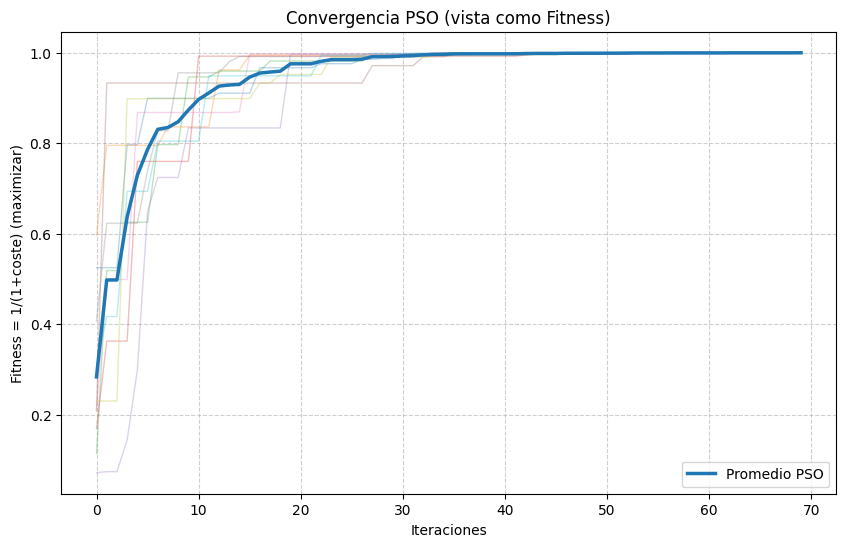

In [173]:
# Convertir coste PSO -> fitness compatible con GA
pso_fitness_histories = []
for h_coste in pso_histories:
    h_fitness = [1.0 / (1.0 + c) for c in h_coste]
    pso_fitness_histories.append(h_fitness)

# Asegurar misma longitud para promediar
min_len = min(len(h) for h in pso_fitness_histories)
pso_fitness_histories = [h[:min_len] for h in pso_fitness_histories]

avg_fitness_pso = np.mean(pso_fitness_histories, axis=0)

# Gráfica fitness PSO
plt.figure(figsize=(10, 6))

for h in pso_fitness_histories:
    plt.plot(h, alpha=0.3, linewidth=1)

plt.plot(avg_fitness_pso, linewidth=2.5, label='Promedio PSO')

plt.title("Convergencia PSO (vista como Fitness)")
plt.xlabel("Iteraciones")
plt.ylabel("Fitness = 1/(1+coste) (maximizar)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Análisis Comparativo: GA Propio vs. PSO (Librería)

Para validar la calidad de nuestra implementación, se compara el rendimiento del Algoritmo Genético (GA) desarrollado frente a una implementación estándar de **Particle Swarm Optimization (PSO)** usando la librería `pyswarms`, manteniendo en ambos casos el mismo presupuesto computacional (3.500 evaluaciones). La figura muestra la evolución en **fitness**. El **GA (azul)** mejora de forma muy rápida en las primeras generaciones y alcanza valores cercanos a 1 en pocas iteraciones, estabilizándose pronto alrededor del óptimo; el **PSO (naranja)** también converge hacia 1, pero lo hace de forma más gradual, necesitando más iteraciones para aproximarse al mismo nivel. En conjunto, ambos métodos llegan a soluciones de alta calidad, aunque el GA presenta una convergencia inicial más rápida y una estabilización temprana, mientras que el PSO progresa de manera más suave hasta acercarse al óptimo.

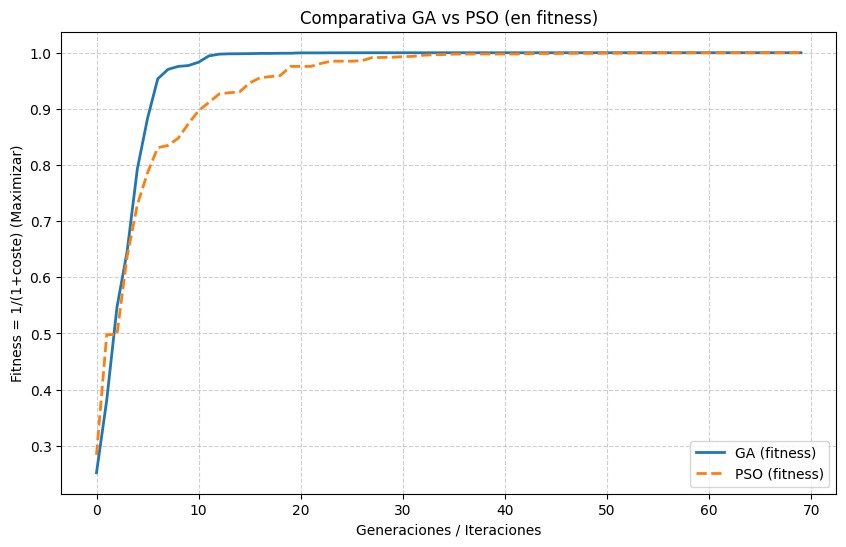

In [174]:
plt.figure(figsize=(10, 6))

m = min(len(avg_history), len(avg_fitness_pso))
plt.plot(avg_history[:m], label="GA (fitness)", linewidth=2)
plt.plot(avg_fitness_pso[:m], label="PSO (fitness)", linestyle="--", linewidth=2)

plt.title("Comparativa GA vs PSO (en fitness)")
plt.xlabel("Generaciones / Iteraciones")
plt.ylabel("Fitness = 1/(1+coste) (Maximizar)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

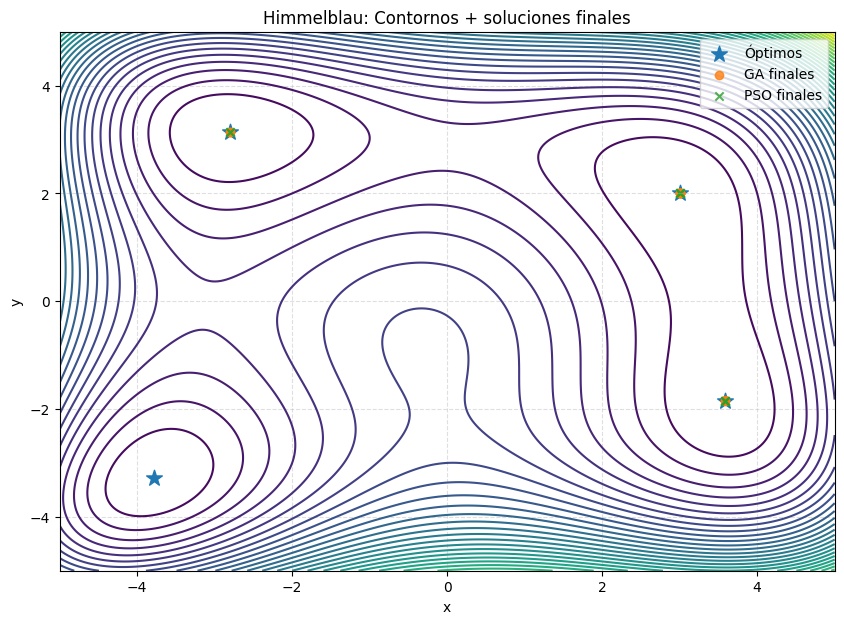

In [175]:
optimos = np.array([
    [ 3.0,  2.0],
    [-2.805118,  3.131312],
    [-3.779310, -3.283186],
    [ 3.584428, -1.848126]
])

xs = np.linspace(-5, 5, 400)
ys = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(xs, ys)
Z = (X**2 + Y - 11)**2 + (X + Y**2 - 7)**2

plt.figure(figsize=(10, 7))
plt.contour(X, Y, Z, levels=40)

ga_xy = np.array(ga_best_solutions)
pso_xy = np.array(pso_best_positions)

plt.scatter(optimos[:,0], optimos[:,1], marker="*", s=140, label="Óptimos")
plt.scatter(ga_xy[:,0], ga_xy[:,1], alpha=0.8, label="GA finales")
plt.scatter(pso_xy[:,0], pso_xy[:,1], marker="x", alpha=0.8, label="PSO finales")

plt.title("Himmelblau: Contornos + soluciones finales")
plt.xlabel("x"); plt.ylabel("y")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

La figura muestra el paisaje de la función de Himmelblau mediante curvas de nivel y superpone los cuatro mínimos globales conocidos (estrellas). Las soluciones finales obtenidas en las 10 ejecuciones tanto del GA (puntos) como del PSO (cruces) aparecen prácticamente sobre esos óptimos, lo que indica que ambos métodos están encontrando mínimos globales y no se quedan atrapados en regiones subóptimas (mínimos locales).

Además, se observa que distintas ejecuciones convergen a mínimos diferentes, lo cual es esperable en una función multimodal como Himmelblau: dependiendo de la inicialización aleatoria, el algoritmo termina en una cuenca de atracción u otra. Por tanto, la gráfica confirma tanto la calidad de las soluciones (cercanas al mínimo global) como la capacidad de exploración de los algoritmos al cubrir varios óptimos posibles.